# Importing Modules and Datasets

## Modules

In [ ]:
# basics modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,12)
import seaborn as sns

#stats
from scipy import sparse
from scipy.stats import pearsonr

#sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

#keras
import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras. layers import dot

#output
pd.set_option('display.max_colwidth', None)

#warnings
import warnings
warnings.simplefilter('ignore')

## Datasets

In [ ]:
movies=pd.read_fwf('zee-movies.dat',encoding='ISO-8859-1')

In [ ]:
ratings=pd.read_fwf('zee-ratings.dat',encoding='ISO-8859-1')

In [ ]:
users=pd.read_fwf('zee-users.dat',encoding='ISO-8859-1')

# Data formatting

In [ ]:
print(movies.head(2))
print()
print(ratings.head(2))
print()
print(users.head(2))

                            Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN

  UserID::MovieID::Rating::Timestamp
0              1::1193::5::978300760
1               1::661::3::978302109

  UserID::Gender::Age::Occupation::Zip-code
0                        1::F::1::10::48067
1                       2::M::56::16::70072


**OBSERVATION:**

All 3 datasets are not in the readable and usable format. Let us format the data to make it readable and usable for analysis

## Movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


**Unnamed: 1** and **Unnamed: 2** columns have more null values. Let's check those columns before we drop them

In [ ]:
movies[~movies['Unnamed: 1'].isnull()].head(3)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
62,63::Don't Be a Menace to South Central While Drinking Your Juice in the,Hood,(1996)::Comedy
197,"199::Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):",Dram,|Musical
235,238::Far From Home: The Adventures of Yellow Dog (1995)::Adventure|Chil,ren',NaN


In [ ]:
movies[~movies['Unnamed: 2'].isnull()].tail(3)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
3626,"3695::Toxic Avenger Part III: The Last Temptation of Toxie, The (1989):",Come,y|Horror
3685,"3754::Adventures of Rocky and Bullwinkle, The (2000)::Animation|Childre",'s|C,medy
3817,3887::Went to Coney Island on a Mission From God... Be Back by Five (19,8)::,rama


In [ ]:
movies=movies.fillna('')

In [ ]:
print(movies.iloc[3626,0]+movies.iloc[3626,1]+movies.iloc[3626,2])
print(movies.iloc[197,0]+movies.iloc[197,1]+movies.iloc[197,2])
print(movies.iloc[235,0]+movies.iloc[235,1]+movies.iloc[235,2])

3695::Toxic Avenger Part III: The Last Temptation of Toxie, The (1989):Comey|Horror
199::Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):Dram|Musical
238::Far From Home: The Adventures of Yellow Dog (1995)::Adventure|Chilren'


**OBSERVATION:**

1. It seems like both the Unnamed columns have some useful information.
2. By combining the values in all 3 columns we almost get the complete information of a few movies that were previously left behind in the unnamed columns.
3. Also splitting using '::' isn't going to give a good result for a few rows.

In [ ]:
(movies['Movie ID::Title::Genres']+movies['Unnamed: 1']+movies['Unnamed: 2']).str.split('::',expand=True).rename({0:'Movie ID',1:'Title',2:'Genres'},axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   object
 1   Title     3883 non-null   object
 2   Genres    3875 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


In [ ]:
mask=(movies['Movie ID::Title::Genres']+movies['Unnamed: 1']+movies['Unnamed: 2']).str.split('::',expand=True).rename({0:'Movie ID',1:'Title',2:'Genres'},axis=1)['Genres'].isnull()
(movies['Movie ID::Title::Genres']+movies['Unnamed: 1']+movies['Unnamed: 2']).str.split('::',expand=True).rename({0:'Movie ID',1:'Title',2:'Genres'},axis=1)[mask]['Title']

,Title
197,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):Dram|Musical"
720,"Institute Benjamenta, or This Dream People Call Human Life (1995):Dram"
1134,"Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982):Draa"
1160,"Double Life of Veronique, The (La Double Vie de Véronique) (1991):Draa"
2721,"Final Conflict, The (a.k.a. Omen III: The Final Conflict) (1981):Horrr"
3017,March of the Wooden Soldiers (a.k.a. Laurel & Hardy in Toyland) (934):Comedy
3133,Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (171):Drama
3626,"Toxic Avenger Part III: The Last Temptation of Toxie, The (1989):Comey|Horror"


In [ ]:
genres_null_index=list((movies['Movie ID::Title::Genres']+movies['Unnamed: 1']+movies['Unnamed: 2']).str.split('::',expand=True).rename({0:'Movie ID',1:'Title',2:'Genres'},axis=1)[mask].index)
genres_null_index

[197, 720, 1134, 1160, 2721, 3017, 3133, 3626]

In [ ]:
movies=pd.DataFrame((movies['Movie ID::Title::Genres']+movies['Unnamed: 1']+movies['Unnamed: 2']),columns=['Movies'])

In [ ]:
movies.iloc[genres_null_index,0]=movies.iloc[genres_null_index,0].str.replace("):",")::")

In [ ]:
movies=movies['Movies'].str.split('::',expand=True).rename({0:'Movie_id',1:'Title',2:'Genres'},axis=1)

In [ ]:
movies['Year']=movies['Title'].str[-5:-1:1]

In [ ]:
movies['Title']=movies['Title'].str[:-6]

In [ ]:
movies.head()

,Movie_id,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_id  3883 non-null   object
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
 3   Year      3883 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


## Ratings

In [ ]:
ratings=ratings['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True).rename({0:'UserID',1:'Movie_id',2:'Rating',3:'Timestamp'},axis=1)

In [ ]:
ratings.head()

,UserID,Movie_id,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   Movie_id   1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


## Users

In [ ]:
users=users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True).rename({0:'UserID',1:'Gender',2:'Age',3:'Occupation',4:'Zipcode'},axis=1)

In [ ]:
users.replace({'Age':{'1': "Under 18",'18': "18-24",'25': "25-34",'35': "35-44",'45': "45-49",'50': "50-55",'56': "56+"}},inplace=True)
users.replace({'Occupation':{
    '0': "other or not specified",
    '1': "academic/educator",
    '2': "artist",
    '3': "clerical/admin",
    '4': "college/grad student",
    '5': "customer service",
    '6': "doctor/health care",
    '7': "executive/managerial",
    '8': "farmer",
    '9': "homemaker",
    '10': "K-12 student",
    '11': "lawyer",
    '12': "programmer",
    '13': "retired",
    '14': "sales/marketing",
    '15': "scientist",
    '16': "self-employed",
    '17': "technician/engineer",
    '18': "tradesman/craftsman",
    '19': "unemployed",
    '20': "writer"}},inplace=True)

In [ ]:
users.head()

,UserID,Gender,Age,Occupation,Zipcode
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zipcode     6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


## Merging

In [ ]:
merge_1=pd.merge(movies,ratings,how='inner',on='Movie_id')
merge_1.head(3)

,Movie_id,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,Animation|Children's|Comedy,1995,1,5,978824268
1,1,Toy Story,Animation|Children's|Comedy,1995,6,4,978237008
2,1,Toy Story,Animation|Children's|Comedy,1995,8,4,978233496


In [ ]:
df=pd.merge(merge_1,users,how='inner',on='UserID')
df.head(3)

,Movie_id,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zipcode
0,1,Toy Story,Animation|Children's|Comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067
1,48,Pocahontas,Animation|Children's|Musical|Romance,1995,1,5,978824351,F,Under 18,K-12 student,48067
2,150,Apollo 13,Drama,1995,1,5,978301777,F,Under 18,K-12 student,48067


# Performing EDA

**Shape of the Dataset:**

In [ ]:
print('No.of rows:',df.shape[0])
print('No. of columns:',df.shape[1])

No.of rows: 1000209
No. of columns: 11


In [ ]:
df['Rating']=df['Rating'].astype('int32')
df['Timestamp']=pd.to_datetime(df['Timestamp'],unit='s')

In [ ]:
df['Year'].unique()

array(['1995', '1977', '1993', '1992', '1937', '1991', '1996', '1964',
       '1939', '1958', '1950', '1941', '1965', '1982', '1975', '1987',
       '1962', '1989', '1985', '1959', '1997', '1998', '1988', '1942',
       '1947', '1999', '1980', '1983', '1986', '1990', '2000', '1994',
       '1978', '1961', '1984', '1972', '1976', '1981', '1973', '1974',
       '1940', '(163', '1952', '1954', '1953', '1944', '1968', '1957',
       '1946', '1949', '1951', '1963', '1971', '1979', '1967', '1966',
       '1948', '1933', '1970', '1969', '1930', '1955', '1956', '(934',
       '1920', '1925', '1938', '(195', '1960', '1935', '1932', '1931',
       '1945', '1943', '(198', '(199', '1934', '1936', '1929', '1926',
       '(993', '1927', '1922', ')199', '1919', '1921', '(190', '1923',
       '1928', '(196', '(171'], dtype=object)

**OBSERVATION:**

Few values in the year are not in the right format. Let's see if we could rectify that.

In [ ]:
non_num_year_mask=df['Year'].str.isnumeric()
non_num_year_index=list(df[~non_num_year_mask].index)
df.drop(index=non_num_year_index,inplace=True)

**Shape of the dataset:**

In [ ]:
print('No.of rows:',df.shape[0])
print('No. of columns:',df.shape[1])

No.of rows: 996944
No. of columns: 11


In [ ]:
df['Year']=df['Year'].astype('int32')

In [ ]:
df.describe()

,Year,Rating,Timestamp
count,996944.000000,996944.000000,996944
mean,1986.755748,3.579934,2000-10-22 20:10:59.166476800
min,1919.000000,1.000000,2000-04-25 23:05:36
25%,1982.000000,3.000000,2000-08-03 11:46:08
50%,1992.000000,4.000000,2000-10-31 19:10:56
75%,1997.000000,4.000000,2000-11-26 06:47:28
max,2000.000000,5.000000,2003-02-28 17:49:52
std,14.312070,1.116935,NaN


The given release year of all the movies are between 1920 and 2000. So let's create a bin for years.

In [ ]:
def create_bins(x):
    if x<1920:
        return '20s'
    elif x<1930:
        return '30s'
    elif x<1940:
        return '40s'
    elif x<1950:
        return '50s'
    elif x<1960:
        return '60s'
    elif x<1970:
        return '70s'
    elif x<1980:
        return '80s'
    else:
        return '90s'

In [ ]:
df['Decade']=df['Year'].apply(create_bins)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996944 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Movie_id    996944 non-null  object        
 1   Title       996944 non-null  object        
 2   Genres      996944 non-null  object        
 3   Year        996944 non-null  int32         
 4   UserID      996944 non-null  object        
 5   Rating      996944 non-null  int32         
 6   Timestamp   996944 non-null  datetime64[ns]
 7   Gender      996944 non-null  object        
 8   Age         996944 non-null  object        
 9   Occupation  996944 non-null  object        
 10  Zipcode     996944 non-null  object        
 11  Decade      996944 non-null  object        
dtypes: datetime64[ns](1), int32(2), object(9)
memory usage: 91.3+ MB


In [ ]:
df.isna().sum()

,0
Movie_id,0
Title,0
Genres,0
Year,0
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0


There isn't any null values in our dataset

In [ ]:
print('No. of Duplicate rows:',df[df.duplicated()].shape[0])

No. of Duplicate rows: 0


## Analysis and Visualization

### Univariate

In [ ]:
cat_columns=[]
num_columns=[]
for cols in list(df.columns):
    if type(df[cols][0])==type('a'):
        cat_columns.append(cols)
    else:
        num_columns.append(cols)

In [ ]:
type(df['Year'][0])

numpy.int32

In [ ]:
cat_columns

['Movie_id',
 'Title',
 'Genres',
 'UserID',
 'Gender',
 'Age',
 'Occupation',
 'Zipcode',
 'Decade']

In [ ]:
num_columns

['Year', 'Rating', 'Timestamp']

**Categorical:**

In [ ]:
print('No. of Unique movies:',df['Movie_id'].nunique())
print('No. of Unique titles:',df['Title'].nunique())
print('No. of Unique Users:',df['UserID'].nunique())
print('No. of Unique region:',df['Zipcode'].nunique())

No. of Unique movies: 3692
No. of Unique titles: 3650
No. of Unique Users: 6040
No. of Unique region: 3439


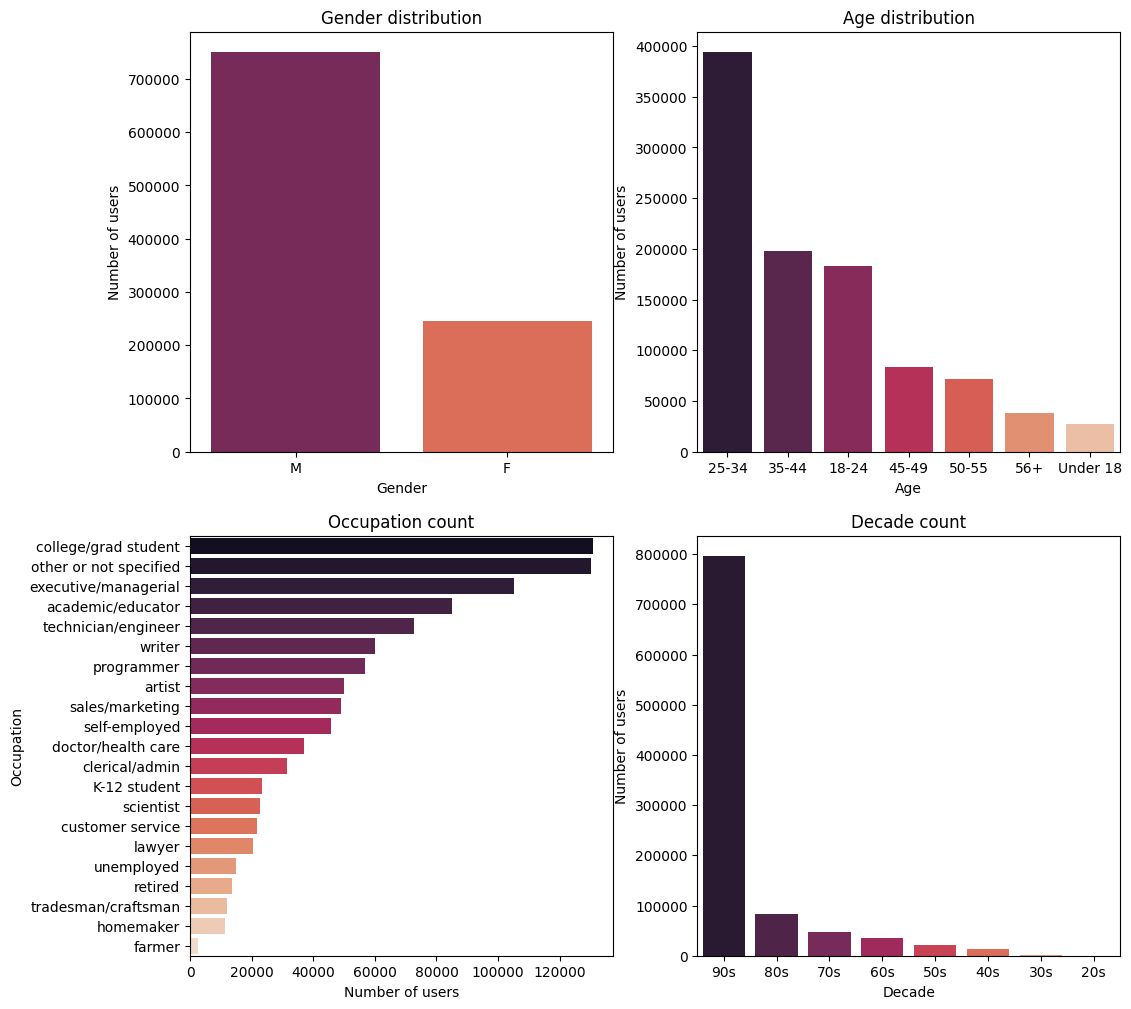

In [ ]:
plt.subplot(2,2,1)
Gender=df.groupby('Gender')['Movie_id'].count().sort_values(ascending=False)
sns.barplot(x=Gender.index,y=Gender.values,palette='rocket')
plt.ylabel('Number of users')
plt.title('Gender distribution')

plt.subplot(2,2,2)
Age=df.groupby('Age')['Movie_id'].count().sort_values(ascending=False)
sns.barplot(x=Age.index,y=Age.values,palette='rocket')
plt.ylabel('Number of users')
plt.title('Age distribution')


plt.subplot(2,2,3)
Occupation=df.groupby('Occupation')['Movie_id'].count().sort_values(ascending=False)
sns.barplot(y=Occupation.index,x=Occupation.values,palette='rocket')
plt.xlabel('Number of users')
plt.title('Occupation count')

plt.subplot(2,2,4)
Decade=df.groupby('Decade')['Movie_id'].count().sort_values(ascending=False)
sns.barplot(x=Decade.index,y=Decade.values,palette='rocket')
plt.title('Decade count')
plt.ylabel('Number of users')
plt.show()

**OBSERVATIONS:**

1. Unique titles are lesser than unique movie id. This means there are multiple movies under same title.
2. Zee has more male users than female users.
3. More than 50% users belong to the age group 18 to 44 and most of the them are college/graduate students and very few farmers use Zee.
4. Most of the movies in the platform are released in 1990s and the count decreases as we go back in time.

**Numerical:**

Rating

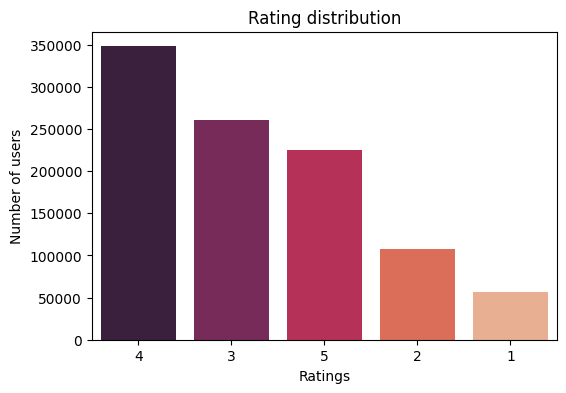

In [ ]:
plt.figure(figsize=(6,4))
Rating=df.groupby('Rating')['UserID'].count().sort_values(ascending=False)
Rating.index=Rating.index.astype('str')
sns.barplot(x=list(Rating.index),y=list(Rating.values),palette='rocket')
plt.xlabel('Ratings')
plt.ylabel('Number of users')
plt.title('Rating distribution')
plt.show()

### Bi-variate

**Average Rating:**

In [ ]:
df.groupby('Title')['Rating'].mean().sort_values(ascending=False)

,Rating
Title,
Schlafes Bruder (Brother of Sleep),5.0
One Little Indian,5.0
Ulysses (Ulisse),5.0
Follow the Bitch,5.0
Bittersweet Motel,5.0
...,...
"Loves of Carmen, The",1.0
Hillbillys in a Haunted House,1.0
"Fantastic Night, The (La Nuit Fantastique)",1.0


**Rating count:**

In [ ]:
df.groupby('Title')['Rating'].count().sort_values(ascending=False)

,Rating
Title,
American Beauty,3428
Star Wars: Episode IV - A New Hope,2991
Star Wars: Episode V - The Empire Strikes Back,2990
Star Wars: Episode VI - Return of the Jedi,2883
Jurassic Park,2672
...,...
Foolish,1
Aiqing wansui,1
White Boys,1


**OBSERVATIONS:**

The movies that have high average rating doesn't have high rating count.

In [ ]:
data=df.groupby('Title')['Rating'].agg(['mean','count']).rename({'mean':'Avg_rating','count':'Rating_count'},axis=1)

In [ ]:
data.sample(3)

,Avg_rating,Rating_count
Title,,
Slam,3.480000,25
"Craft, The",3.086538,416
Ulee's Gold,3.661654,266


# Creating Recommendation System

In [ ]:
matrix=pd.pivot_table(df,index='UserID',columns='Title',values='Rating',aggfunc='mean').fillna(0)

In [ ]:
print('No. of rows:',matrix.shape[0])
print('No. of columns:',matrix.shape[1])

No. of rows: 6040
No. of columns: 3650


In [ ]:
matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0


## Pearson Correlation

In [ ]:
movie_name=input('Enter a movie name:')

Enter a movie name:Liar Liar 


In [ ]:
movie_rating=matrix[movie_name]
movie_rating

,Liar Liar
UserID,
1,0.0
10,0.0
100,0.0
1000,0.0
1001,0.0
...,...
995,0.0
996,0.0
997,0.0


In [ ]:
similar_movies=matrix.corrwith(movie_rating)

In [ ]:
similar_movies

,0
Title,
"$1,000,000 Duck",0.063723
'Night Mother,0.048226
'Til There Was You,0.073924
"'burbs, The",0.225559
...And Justice for All,0.074494
...,...
"Zed & Two Noughts, A",0.014045
Zero Effect,0.174860
Zero Kelvin (Kjærlighetens kjøtere),-0.006114


In [ ]:
sim_mov_df=pd.DataFrame(similar_movies,columns=['Correlation'])
sim_mov_df.sort_values('Correlation',ascending=False,inplace=True)
print('Top 10 similar movies to'+' "'+movie_name+'"')
sim_mov_df[1:11]

Top 10 similar movies to "Liar Liar "


,Correlation
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222
Wayne's World,0.424552
"Cable Guy, The",0.420942
Tommy Boy,0.413143
Austin Powers: International Man of Mystery,0.411105


## Cosine Similarity

**Item-Item Similarity**

In [ ]:
item_sim_matrix=pd.DataFrame(cosine_similarity(matrix.T), index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [ ]:
similar_item=item_sim_matrix[movie_name]
similar_item.head()

,Liar Liar
Title,
"$1,000,000 Duck",0.083874
'Night Mother,0.078287
'Til There Was You,0.097655
"'burbs, The",0.276145
...And Justice for All,0.126206


In [ ]:
similar_item_df=similar_item.to_frame(name='Similarity')
similar_item_df.sort_values('Similarity',ascending=False,inplace=True)
print('Top 10 similar movies to'+' "'+movie_name+'"')
similar_item_df[1:11]

Top 10 similar movies to "Liar Liar "


,Similarity
Title,
Mrs. Doubtfire,0.557067
Ace Ventura: Pet Detective,0.516861
Dumb & Dumber,0.512585
Home Alone,0.511204
Wayne's World,0.499368
"Wedding Singer, The",0.497076
Austin Powers: International Man of Mystery,0.489473
There's Something About Mary,0.483263
"League of Their Own, A",0.482074


**User-User similarity**

In [ ]:
user_sim_matrix=pd.DataFrame(cosine_similarity(matrix),index=matrix.index,columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


In [ ]:
user_id=input('Enter the user id:')

Enter the user id:52


In [ ]:
similar_user=user_sim_matrix[user_id]

In [ ]:
similar_user_df=similar_user.to_frame(name='Similarity')
similar_user_df.sort_values('Similarity',ascending=False,inplace=True)
print('Users similar to user id'+' "'+str(user_id)+'"')
similar_user_df[1:11]

Users similar to user id "52"


,Similarity
UserID,
4569,0.522862
3968,0.446395
1640,0.433370
3553,0.432688
4390,0.427967
4004,0.423975
4601,0.421070
3599,0.419843
915,0.414777


## KNN

In [ ]:
csr_matrix=sparse.csr_matrix(matrix.T.values)
csr_matrix

<3650x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 993820 stored elements in Compressed Sparse Row format>

In [ ]:
knn=NearestNeighbors(n_neighbors=5,metric='cosine',n_jobs=-1)
knn.fit(csr_matrix)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [ ]:
distance,index=knn.kneighbors(matrix[movie_name].values.reshape(1,-1),n_neighbors=11)

In [ ]:
knn_similar_movies=pd.DataFrame({'movies':matrix.columns[index.flatten()],'distance':np.round(distance.flatten(),2)})
knn_similar_movies.sort_values('distance',inplace=True)
print('Top 10 similar movies to'+' "'+movie_name+'"')
knn_similar_movies[1:]

Top 10 similar movies to "Liar Liar "


,movies,distance
1,Mrs. Doubtfire,0.44
2,Ace Ventura: Pet Detective,0.48
3,Dumb & Dumber,0.49
4,Home Alone,0.49
5,Wayne's World,0.50
6,"Wedding Singer, The",0.50
7,Austin Powers: International Man of Mystery,0.51
8,There's Something About Mary,0.52
9,"League of Their Own, A",0.52
10,"Mask, The",0.53


## Matrix Factorization

**Creating embeddings for users and items:**

In [ ]:
users=df['UserID'].unique()
items=df['Movie_id'].unique()

In [ ]:
user_embeddings={}
for i in range(len(users)):
    if str(users[i]) not in user_embeddings:
        user_embeddings[str(users[i])]=i

In [ ]:
item_embeddings={}
for i in range(len(items)):
    if str(items[i]) not in item_embeddings:
        item_embeddings[str(items[i])]=i

In [ ]:
df['UserID']=df['UserID'].apply(lambda x: user_embeddings[x])
df['Movie_id']=df['Movie_id'].apply(lambda x: item_embeddings[x])

In [ ]:
split=np.random.rand(len(df))<0.8
train_df=df[split]
valid_df=df[~split]
print(train_df.shape,valid_df.shape)

(797034, 12) (199910, 12)


In [ ]:
n_users=df['UserID'].nunique()
n_items=df['Movie_id'].nunique()

In [ ]:
#user embedding
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,64,name='user_embedding')(user_input)
user_vector=Flatten(name='FlattenUsers')(user_embedding)

#movie embedding
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_items,64,name='movie_embedding')(movie_input)
movie_vector=Flatten(name='FlattenMovies')(movie_embedding)

In [ ]:
similar=dot([user_vector,movie_vector],name='Similarity-Dot-Product',axes=1)
model=keras.models.Model([user_input,movie_input],similar)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='mse')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 64)          │        386,560 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 64)          │        236,288 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FlattenUsers (Flatten)    │ (None, 64)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FlattenMovies (Flatten)   │ (None, 64)             │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Similarity-Dot-Product    │ (None, 1)              │              0 │ FlattenUsers[0][0],    │
│ (Dot)                     │                        │                │ FlattenMovies[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 622,848 (2.38 MB)

 Trainable params: 622,848 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_train=model.fit([train_df.UserID,train_df.Movie_id],train_df.Rating,batch_size=128,epochs=20,
validation_data=([valid_df.UserID,valid_df.Movie_id],valid_df.Rating),verbose=1)

Epoch 1/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 14.0554 - val_loss: 13.6243
Epoch 2/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 12.1735 - val_loss: 5.7264
Epoch 3/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 4.3397 - val_loss: 2.1356
Epoch 4/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - loss: 1.8324 - val_loss: 1.3176
Epoch 5/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - loss: 1.2076 - val_loss: 1.0476
Epoch 6/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 0.9945 - val_loss: 0.9395
Epoch 7/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.9030 - val_loss: 0.8912
Epoch 8/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 0.8630 - val_loss: 0.8671
Epoch 9/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.8424 - val_loss: 0.8542
Epoch 10/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - loss: 0.8317 - val_loss: 0.8468
Epoch 11/20
6227/6227 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - loss: 0.8241 - val_loss: 0.8420
Epoch 12/20

In [ ]:
y_pred=model.predict([valid_df['UserID'],valid_df['Movie_id']],verbose=0)

# Performance

In [ ]:
print('Mean Squared Error:',mse(valid_df['Rating'],y_pred))
print('Mean Absolute Percentage Error:',mape(valid_df['Rating'],y_pred))

Mean Squared Error: 0.7977054569239891
Mean Absolute Percentage Error: 0.2749746082480718
